# packages and imports

In [79]:
import jax.numpy as jnp
import numpy as np
import jax
import optax
from jaxopt import LBFGS
import scipy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import equinox as eqx
import scipy.linalg
from jax.nn.initializers import he_normal
from tqdm import tqdm
#import ipympl
from matplotlib import cbook, cm
from matplotlib.colors import LightSource

seed = 42
np.random.seed(seed)
key = jax.random.key(seed)
num_bases = 10
num_trunk_epochs = 10000
lr = 1e-3
num_LBFGS_epochs = 10000
t_stride = 20
eps = 1e-8 # to prevent loss overflow

print("\nconfiguring backend...")
jax.config.update("jax_platform_name", "metal")


print("backend selected:\n", jax.default_backend())
print("active devices:\n", jax.devices())
print("--------------------\n")


configuring backend...
backend selected:
 METAL
active devices:
 [METAL(id=0)]
--------------------



In [80]:
## EQUINOX CLASS DEFINITIONS
# Linear Model (Wx + b)
class Linear(eqx.Module):
    weight: jax.Array
    bias: jax.Array

    def __init__(self, in_size, out_size, key, initializer = he_normal()):
        wkey, bkey = jax.random.split(key)
        self.weight = initializer(wkey, (out_size, in_size), dtype=jnp.float32)
        self.bias = jnp.zeros((out_size,), dtype=jnp.float32)

    def __call__(self, x):
        return self.weight @ x + self.bias


# Basic MultiLayer Perceptron Primitive
class MLP(eqx.Module):
    layers: list
    activations: list

    def __init__(self, architecture, key, activation = jax.nn.relu, initializer = he_normal()):
        """
        architecture: List[in, hidden1, hidden2, ..., out]
        key: random key
        activation: jax.nn act fxn
        """
        keys = jax.random.split(key, len(architecture) - 1)
        self.layers = [
            Linear(architecture[i], architecture[i+1], keys[i], initializer = initializer) for i in range(len(architecture) - 1)]
        self.activations = [activation] * (len(self.layers) - 1) + [eqx.nn.Identity()] # no activation on last layer

    def __call__(self, x):
        for layer, act in zip(self.layers, self.activations):
            x = act(layer(x))
        return x

## loading dataset

In [81]:
# load external dataset
# NOTE we're loading t, and subsampling every t_stride steps
dataset = np.load('/Users/haydenoutlaw/Documents/Research/opnet/deep-operator-networks/data/burgers_dataset.npz', allow_pickle = True)
t_grid = jnp.array(dataset['t'])
t_grid = t_grid[::t_stride] #subsampling t every t_stride
x_grid = jnp.array(dataset['x'])
print("grid is (t,x) = ", len(t_grid), len(x_grid))

data = dataset['samples']
u = np.array([i['params'] for i in data])
s = np.array([i['solution'] for i in data]) # s is shape (n, t, x)

# disabled functionality for train/test split for now
#n_samp = len(data)
#train_indices, test_indices = train_test_split(np.arange(n_samp), test_size = 0.0, random_state = seed)
#u_train, u_test = jnp.array(u[train_indices]), jnp.array(u[test_indices])
#s_train, s_test = jnp.array(s[train_indices]), jnp.array(s[test_indices])

u_train, s_train = u,s
print('dataset size is (n, coord) = ', u_train.shape)

grid is (t,x) =  11 201
dataset size is (n, coord) =  (441, 2)


## generating data objects

In [82]:
# flatten into list of coordinates (x,t)
xx, tt = jnp.meshgrid(x_grid,t_grid)
xt_grid = jnp.concatenate([xx.flatten()[:,None], tt.flatten()[:,None]], axis=1) #xt_grid[:,0] is x, xt_grid[:,1] is t
print("xt_grid is of shape (n, coord) = ",xt_grid.shape)

output_tr = jnp.transpose(s_train[:,:,::t_stride], axes=(2,1,0)) # (n,x,t) -> (t,x,n). subselecting every t_stride indices of t! 
print("formatted training data output_tr is of shape (t,x,n) = ", output_tr.shape)

xt_grid is of shape (n, coord) =  (2211, 2)
formatted training data output_tr is of shape (t,x,n) =  (11, 201, 441)


## initializing model, loss_fn

In [83]:
u_dim = 2 # in this case, two 
y_dim = 2 # (t,x)
# define architectures for component networks
branch_arch = [u_dim, 40, 40, num_bases] 
trunk_arch  = [y_dim, 40, 40, num_bases] 

key, subkey_t, subkey_A = jax.random.split(key, num=3)
trunk_model = MLP(trunk_arch,key = subkey_t)
A_model = jax.random.normal(subkey_A, (len(t_grid), num_bases, s_train.shape[0])) # now A_model is a 3-tensor -- indexed as t, branch, n. as opposed to one matrix for entire xt domain
print("A_model is shape:", A_model.shape)

model = trunk_model, A_model

def loss_fn(model):
    trunk_model, A_model = model
    T_MAT = jax.vmap(lambda t: jax.vmap(lambda x: trunk_model(jnp.stack([x,t])))(x_grid))(t_grid) # trunk model matrix. output of model given input entire [x_grid, t_grid]
    pred_y = jnp.einsum("txN, tNk -> txk",T_MAT, A_model) # einsum is a tensor contraction. keep t index (time) and at each t index, do (x,N) times (N,k) -> (x,k). N = num_fxns, k = num_samples
    # pred_y[i,:,:] = T_mat[i,:,:] @ A_model[i,:,:], T_mat @ A_model for each individual time, analogous to vanilla case
    return jnp.mean((output_tr - pred_y) ** 2)/jnp.mean(output_tr ** 2) + eps # rel mean squared error

A_model is shape: (11, 10, 441)


In [84]:
opt = optax.adam(lr)
opt_state = opt.init(eqx.filter(model, eqx.is_inexact_array))

loss_hist = []
# standard eqx training step
@eqx.filter_jit
def train_step(model, opt_state):
    loss, grads = eqx.filter_value_and_grad(loss_fn)(model)
    updates, opt_state = opt.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss

for step in range(num_trunk_epochs):
    model, opt_state, loss = train_step(model, opt_state)
    loss_hist.append(float(loss)) # store as list
    if step % 100 == 0: # new carriage print, avoid tqdm for memory
        print(f"\rAdam step {step}: loss={float(loss):.3e}", end="", flush=True)

print("\nfinal adam loss:", loss)


## LBFGS disabled for now. rebuild to match adam
# opt = optax.lbfgs()

# for step in range(num_LBFGS_epochs):
#     model, opt_state, loss = train_step(model, opt_state, (xt_grid, ss_grid))
#     loss_hist.append(float(loss))
#     if step % 1000 == 0:
#         print(f"LBFGS step {step}: loss={float(loss):.3e}")


Adam step 9900: loss=1.599e-03
final adam loss: 0.0009323295


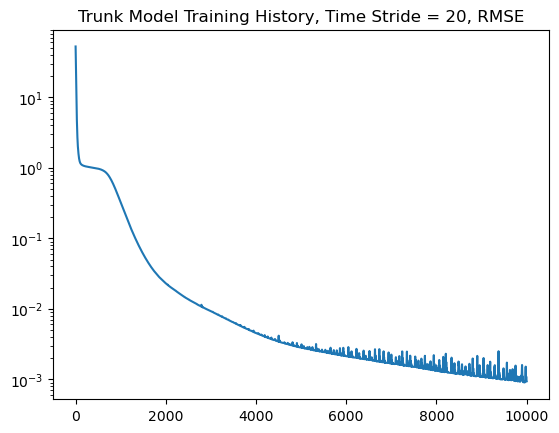

In [85]:
plt.plot(loss_hist)
plt.title(f"Trunk Model Training History, Time Stride = {t_stride}, RMSE")
plt.yscale('log')

## QR Factorizations at Time Data

In [86]:
# SAME LOGIC AS ABOVE - T_MAT is trunk matrix output of entire [x_grid, t_grid]
T_MAT = jax.vmap(lambda t: jax.vmap(lambda x: trunk_model(jnp.stack([x,t])))(x_grid))(t_grid)
print("T_MAT is shape (t,x,n) = ", T_MAT.shape)
# Q_MAT = []

# for index i of t_grid (subsampled here every 2)
for i in range(len(t_grid)):
    # take QR of T_MAT[i,:,:]
    Q,R = scipy.linalg.qr(T_MAT[i], mode = 'economic')
    if i == 0:
        Q_MAT = Q[jnp.newaxis,:,:] # make the 3 tensor
    else:
        Q_MAT = jnp.concatenate([Q_MAT, Q[jnp.newaxis,:,:]], axis=0) # stack Q_MAT in first dimension
    
print("Q_MAT is of shape (t,x,n) = ", Q_MAT.shape)
print("shapes agree?", Q_MAT.shape == T_MAT.shape)

T_MAT is shape (t,x,n) =  (11, 201, 10)
Q_MAT is of shape (t,x,n) =  (11, 201, 10)
shapes agree? True


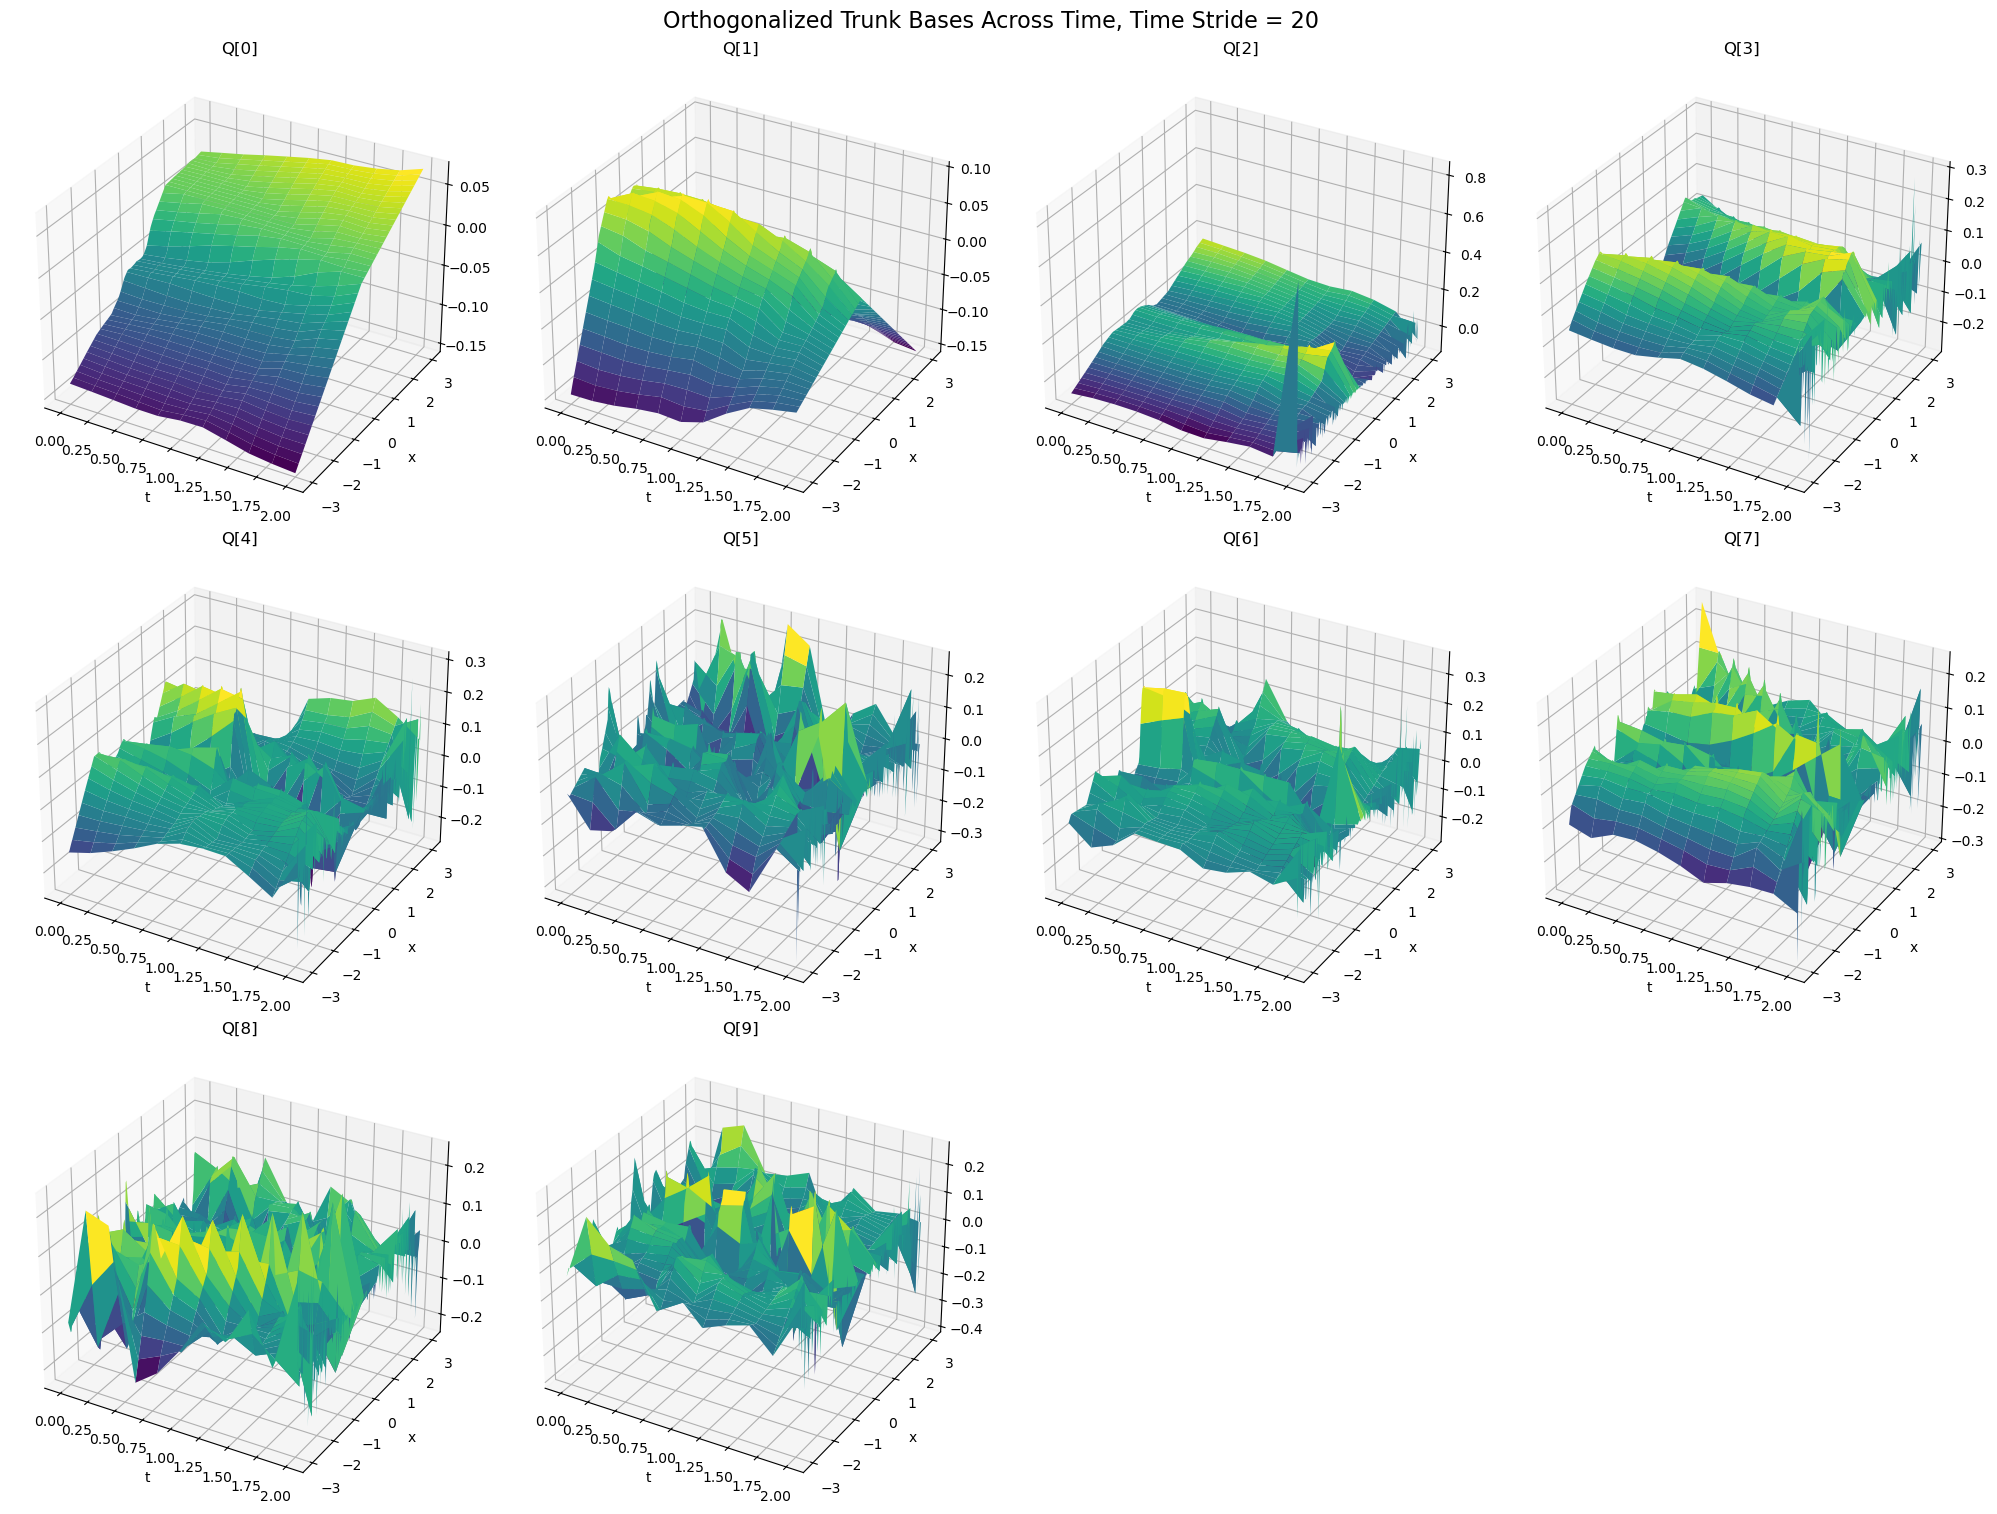

In [87]:
ncols = 4
nrows = int(np.ceil(num_bases / ncols))
T, X = np.meshgrid(t_grid[::], x_grid, indexing="ij") 

fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows), constrained_layout=True, subplot_kw = dict(projection = '3d'))

# flatten axes array for easy indexing
axes = axes.flatten()

for k, ax in enumerate(axes):
    if k < num_bases:
        Q_k = Q_MAT[:,:,k]
        im = ax.plot_surface(T[::-1],X,Q_k, cmap = 'viridis')
        ax.set_title(f"Q[{k}]")
        ax.set_xlabel("t")
        ax.set_ylabel("x")
    else:
        ax.axis("off")

fig.suptitle(f"Orthogonalized Trunk Bases Across Time, Time Stride = {t_stride}", fontsize=16)
plt.show()


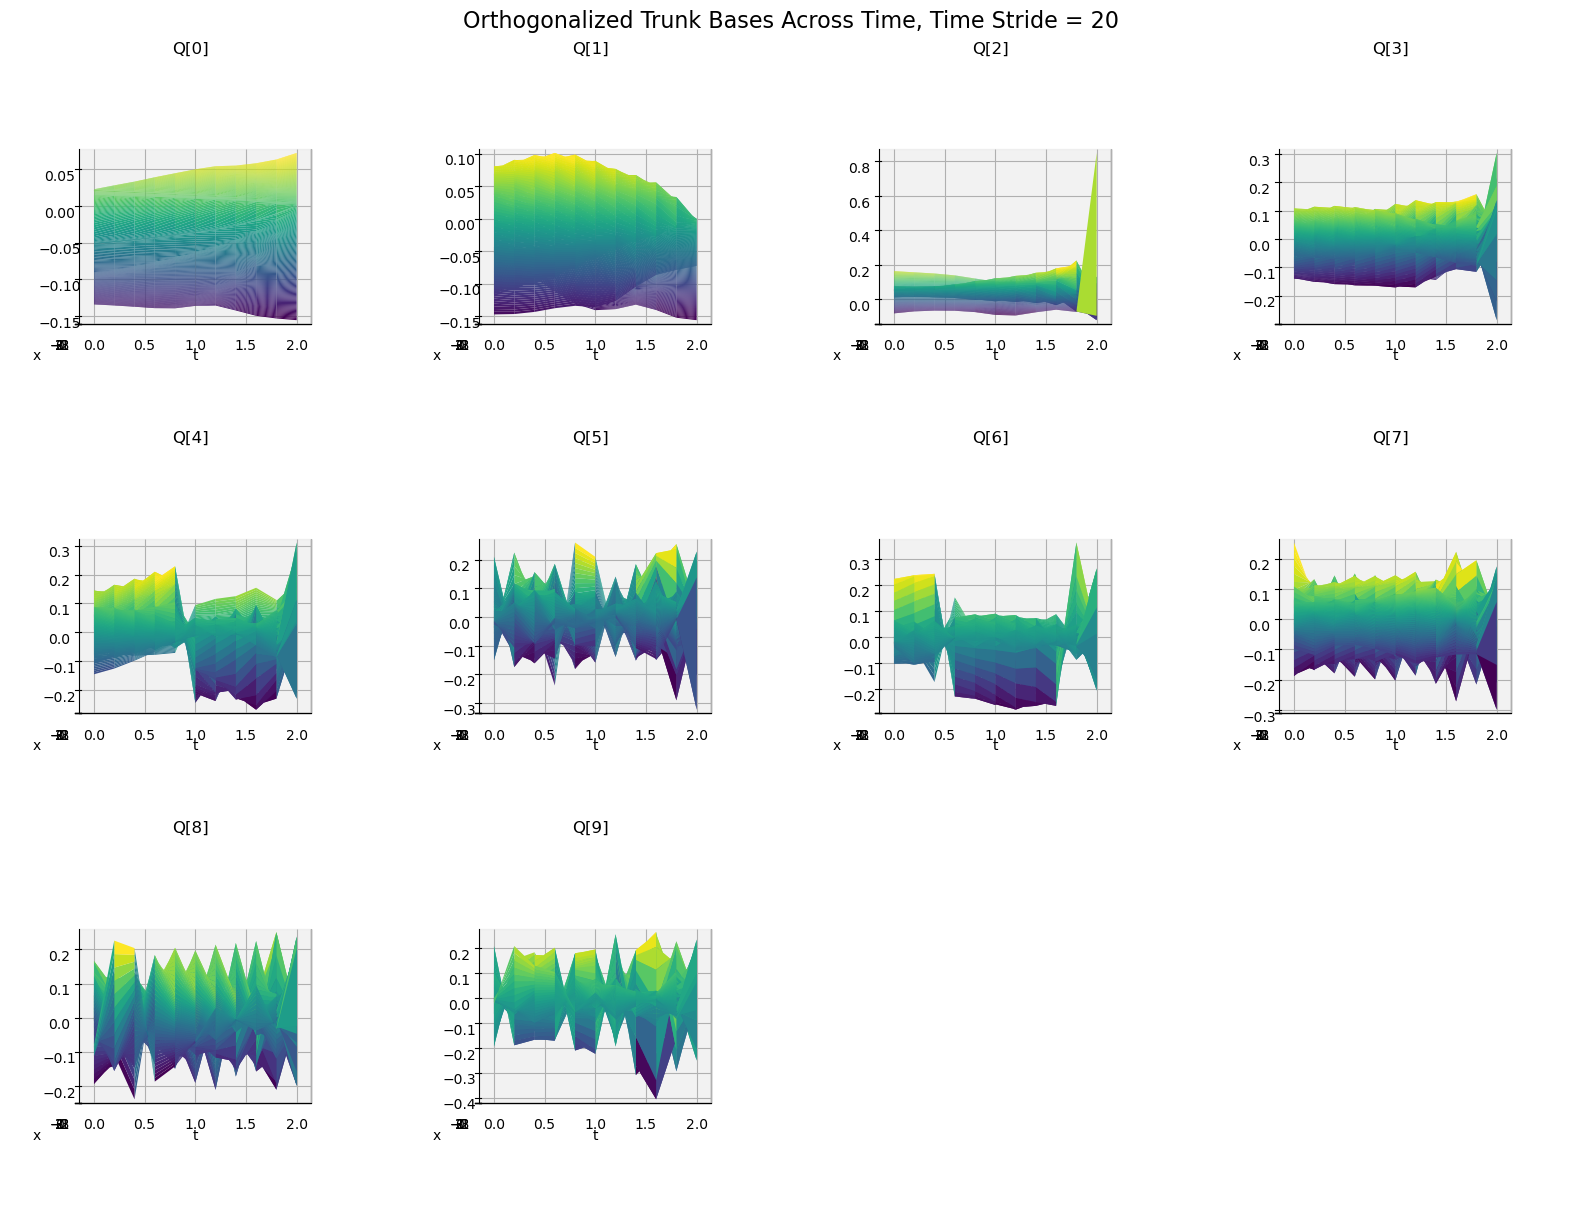

In [88]:
fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows), constrained_layout=True, subplot_kw = dict(projection = '3d'))

# flatten axes array for easy indexing
axes = axes.flatten()

for k, ax in enumerate(axes):
    if k < num_bases:
        Q_k = Q_MAT[:,:,k]
        im = ax.plot_surface(T[::-1],X,Q_k, cmap = 'viridis', rstride = 1, cstride = 1)
        ax.set_title(f"Q[{k}]")
        ax.set_xlabel("t")
        ax.set_ylabel("x")
        ax.grid(True)
        try:
            ax.set_proj_type("ortho")
        except Exception:
            pass
        ax.grid(True)
    else:
        ax.axis("off")
    ax.view_init(elev=0, azim=270)

    

fig.suptitle(f"Orthogonalized Trunk Bases Across Time, Time Stride = {t_stride}", fontsize=16)
plt.show()


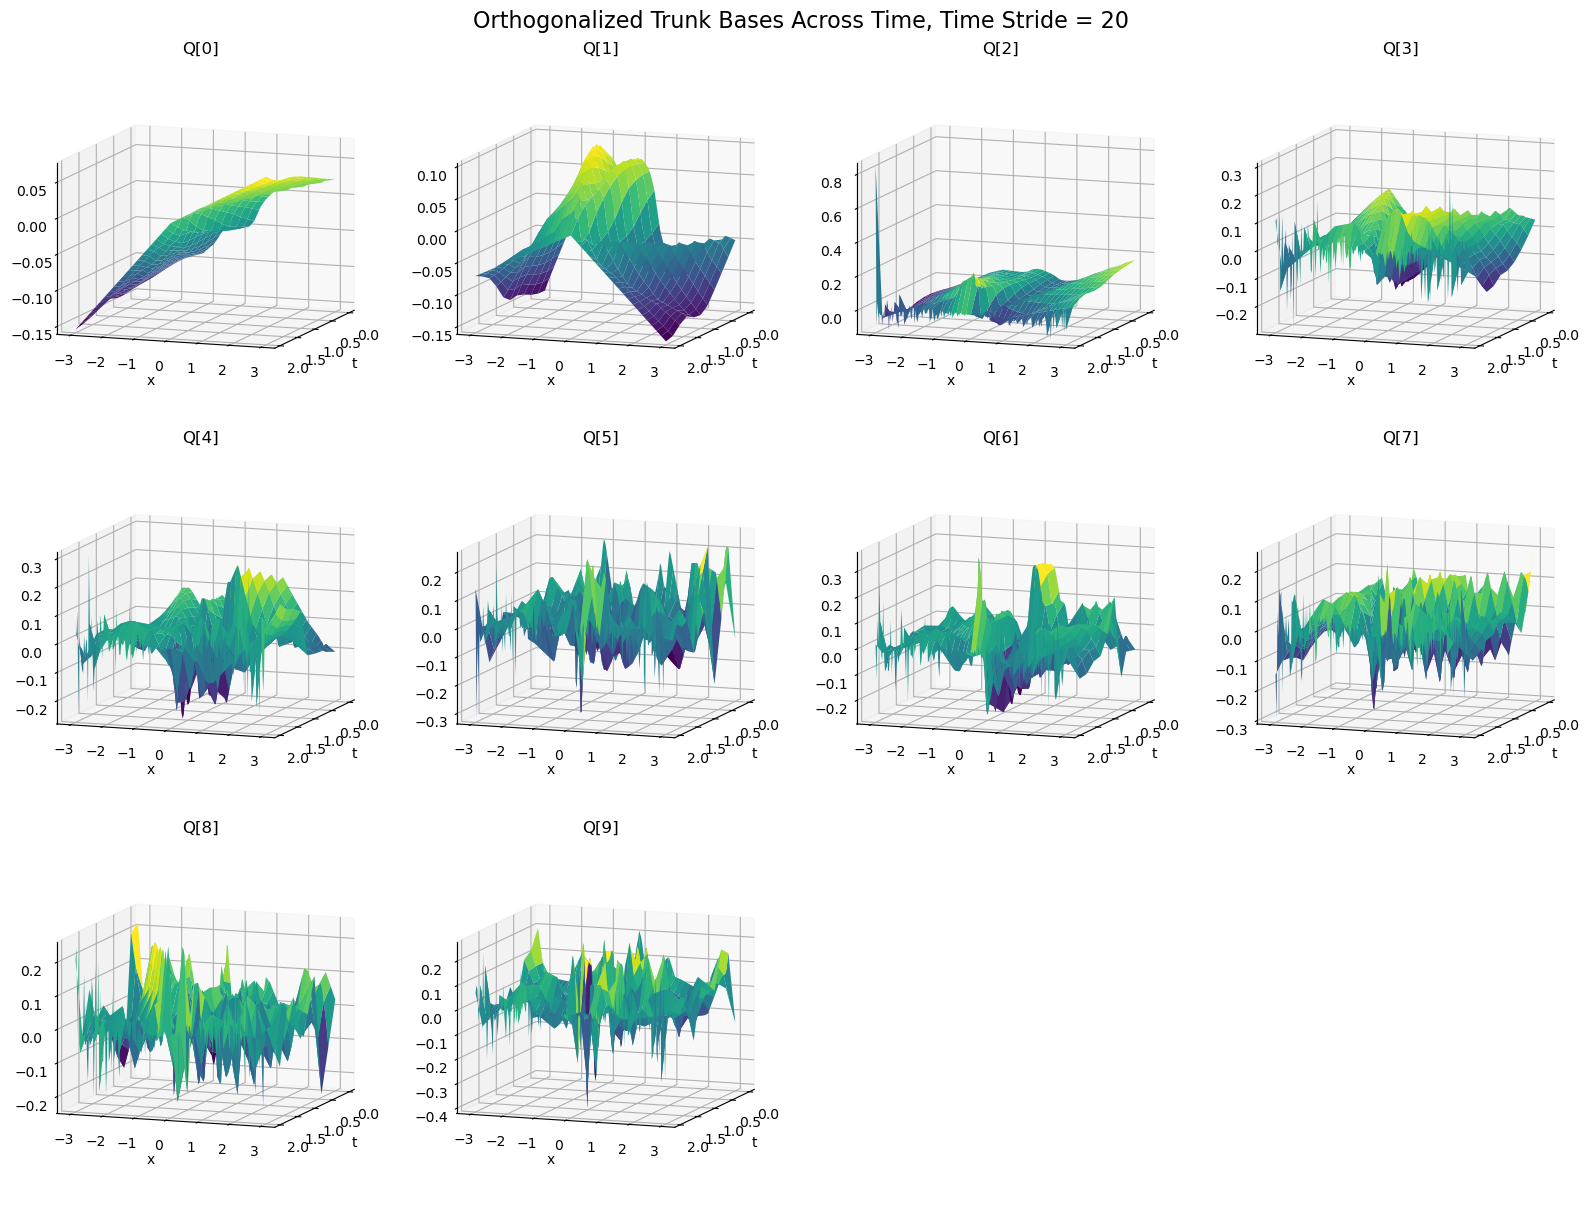

In [89]:

fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows), constrained_layout=True, subplot_kw = dict(projection = '3d'))

# flatten axes array for easy indexing
axes = axes.flatten()

for k, ax in enumerate(axes):
    if k < num_bases:
        Q_k = Q_MAT[:,:,k]
        im = ax.plot_surface(T[::-1],X,Q_k, cmap = 'viridis')

        #im = ax.plot_surface(T,X,Q_k, cmap = 'viridis', rstride = 1, cstride = 1)
        ax.set_title(f"Q[{k}]")
        ax.set_xlabel("t")
        ax.set_ylabel("x")
        ax.grid(True)
        try:
            ax.set_proj_type("ortho")
        except Exception:
            pass
        ax.grid(True)
    else:
        ax.axis("off")
    #ax.view_init(elev=35, azim=10)
    ax.view_init(elev = 10, azim = 20)

    

fig.suptitle(f"Orthogonalized Trunk Bases Across Time, Time Stride = {t_stride}", fontsize=16)
plt.show()
